# <font color='#fff200'> **Notebook Purpose and Introduction**

### **Purpose**
To create a classifier that can determine whether a piece is significant or insignificant [pieces that solely contain randomizations - a.k.a the randomMono.wav / randomPoly.wav files].

### **Introduction**
The classifier helps in assessing the quality and meaningfulness of generated music [at its most basic level]. It distinguishes between music pieces that exhibit intentional musical structure, such as tonality, meter, and melodic patterns, and those that consist solely of random notes.

# <font color='#fff200'> **Next Steps [in Progress]**

Currently, we are at the stage of creating a classifier that can determine whether a piece is significant or insignificant [pieces that solely contain randomizations - a.k.a the randomMono.wav / randomPoly.wav files].

However, I want to take this to the next stage. I want to create / modify a model that can generate unique pieces, but similar-sounding music to files it has previously heard. My input would be the significant pieces I already have, and I want it to listen to those pieces, then create a unique, but similar sounding piece. I would then run a classifier determing whether that generated piece is significant or insignificant.

As of now, the classifier is trained to differentiate between "randomized" music and significant pieces of music. I think a more meaningful classification would be taking the different factors that determine significance [such as "'% In-Tune Notes', 'Rhythmic Stability', 'Note Distribution Stability', 'Melodic Stability Range', 'Dynamic Variation'"]. I believe this is a better approach for classifying the generated pieces, as I predict them to be "slightly significant." It would be hard to do binary classification on the piece as a whole, but easier for binary classification on the factors determining the significance of the piece.

Essentially, the there are two things I want to do: [1] Create a model that can generate unique, but similar sounding pieces based on previously heard pieces and [2] Modify my classification model to binary classify the different factors composing "significance" [such as "'% In-Tune Notes', 'Rhythmic Stability', 'Note Distribution Stability', 'Melodic Stability Range', 'Dynamic Variation'"] as significant or not rather than classify the piece as a whole [current implementation].


*   Something to think about:

 * How would I train the classifier to determine whether one piece is significant or not? Do I manually label the generated pieces as significant or not?

 * Can you control each factor [in-tune notes, rhythmic stability, etc.] Try to construct pieces that isolate certain factors [such as a piece that is just out of tune].

 * Publishing: Explore Peer Review Journals and Archive Simultaneously.





# **Necessary Libraries and Installations**

In [ ]:
!pip install scikeras

In [ ]:
!pip install python_speech_features

In [ ]:
!pip install eli5

In [ ]:
import pandas as pd
import numpy as np
import wave
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import eli5

from scipy.io import wavfile
from python_speech_features import mfcc
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from eli5.sklearn import PermutationImportance
from scikeras.wrappers import KerasClassifier

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Audio Classification Model 1 [KNN]**


Accuracy: 1.0

Precision: 1.0

Recall: 1.0



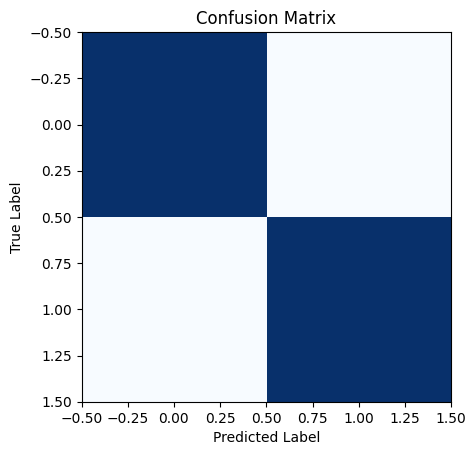

In [ ]:
def extractFeatures(audioFilePath):
    with wave.open(audioFilePath, "rb") as wav_file:                            # Opening the file in read-binary mode.
        num_channels = wav_file.getnchannels()                                  # Number of channels [mono or stereo --> audio from one source / multiple sources]
        rate = wav_file.getframerate()
        sig = wav_file.readframes(-1)                                           # Reads all audio frames from the file.
        sig = np.frombuffer(sig, dtype=np.int16)                                # Converting raw audio data to NumPy array.

    if num_channels == 1: # If mono audio detected
        sig = sig[:, np.newaxis]                                                # Reshape for consistency with stereo data.

    mfcc_feat = mfcc(sig, rate, winlen = 0.020, nfft = 1024, appendEnergy = False) # Calculating MFCC Features.
    mean_matrix = mfcc_feat.mean(0)                                             # Calculating mean of each MFCC coefficient across all frames.
    covariance = np.cov(np.transpose(mfcc_feat))                                # Calculating covariance matrix of MFCC features.
    return np.concatenate([mean_matrix, covariance.flatten()])                  # Concatenated array of mean matrix and flattened covariance matrix as the extracted features.

def train(features, labels):
    return features, labels                                                     # No training necessary on data.

def predict(features, labels, newFeature, k = 5):
    distances = np.linalg.norm(features - newFeature, axis = 1)                 # Calculating Euclidean distances between new feature and all training features.
    nearest_neighbors = np.argsort(distances)[:k]                               # Finds indices of k nearest neighbors based on distances.
    neighbor_labels = labels[nearest_neighbors]
    if neighbor_labels.dtype != int:                                            # Ensuring labels are integers for counting
        neighbor_labels = neighbor_labels.astype(int)
    counts = np.bincount(neighbor_labels)                                       # Counts occurrences of each unique label among k nearest neighbors.
    return counts.argmax().astype(labels.dtype)                                 # Returns most frequent label among k nearest neighbors as predicted label.

csvFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTrain.csv"
csvFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTrain.csv"
csvFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTrain.csv"
trainData = pd.read_csv(csvFileMono)                                            #### Marker to change variable name when processing different CSV.

trainBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTrain[100]/"
trainBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTrain[100]/"
trainBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTrain[100]/"

selected_columns = ['% In-Tune Notes', 'Rhythmic Stability', 'Note Distribution Stability',
                    'Melodic Stability Range', 'Dynamic Variation']
features = []
labels = np.array([])

for index, row in trainData.iterrows():
    labels = np.concatenate((labels, [int(row['Significant'])]))
    audioFilePath = trainBasePathMono + row['Filename']                         #### Marker to change variable name when processing different CSV.
    features.append(extractFeatures(audioFilePath))                             # Extracting features from audio file.

trainedFeatures, trainedLabels = train(features, labels)

testCSVFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTest.csv"
testCSVFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTest.csv"
testCSVFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTest.csv"
testData = pd.read_csv(testCSVFileMono)                                         #### Marker to change variable name when processing different CSV.

testBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTest[50]/"
testBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTest[50]/"
testBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTest[52]/"

yTrue = np.array([int(row['Significant']) for index, row in testData.iterrows()])
yPredicted = []
for index, row in testData.iterrows():
    audioFilePath = testBasePathMono + row['Filename']                          #### Marker to change variable name when processing different CSV.
    newFeature = extractFeatures(audioFilePath)                                 # Extracting features from audio file.
    prediction = predict(trainedFeatures, trainedLabels, newFeature)            # Predicting the label for current test audio.
    yPredicted.append(prediction)

accuracy = accuracy_score(yTrue, yPredicted)
precision = precision_score(yTrue, yPredicted)
recall = recall_score(yTrue, yPredicted)
print("Accuracy:", accuracy)
print()
print("Precision:", precision)
print()
print("Recall:", recall)
print()

cm = confusion_matrix(yTrue, yPredicted)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.96

Precision: 0.9259259259259259

Recall: 1.0



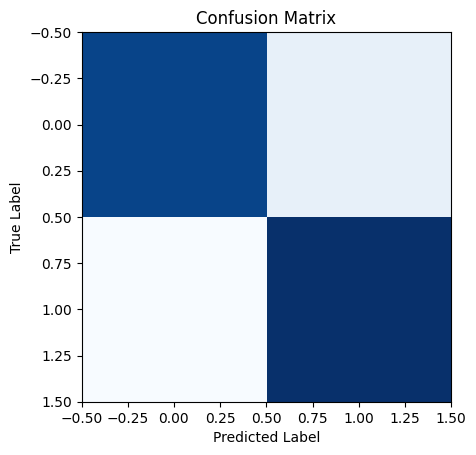

In [ ]:
def extractFeatures(audioFilePath):
    with wave.open(audioFilePath, "rb") as wav_file:                            # Opening the file in read-binary mode.
        num_channels = wav_file.getnchannels()                                  # Number of channels [mono or stereo --> audio from one source / multiple sources]
        rate = wav_file.getframerate()
        sig = wav_file.readframes(-1)                                           # Reads all audio frames from the file.
        sig = np.frombuffer(sig, dtype=np.int16)                                # Converting raw audio data to NumPy array.

    if num_channels == 1: # If mono audio detected
        sig = sig[:, np.newaxis]                                                # Reshape for consistency with stereo data.

    mfcc_feat = mfcc(sig, rate, winlen = 0.020, nfft = 1024, appendEnergy = False) # Calculating MFCC Features.
    mean_matrix = mfcc_feat.mean(0)                                             # Calculating mean of each MFCC coefficient across all frames.
    covariance = np.cov(np.transpose(mfcc_feat))                                # Calculating covariance matrix of MFCC features.
    return np.concatenate([mean_matrix, covariance.flatten()])                  # Concatenated array of mean matrix and flattened covariance matrix as the extracted features.

def train(features, labels):
    return features, labels                                                     # No training necessary on data.

def predict(features, labels, newFeature, k = 5):
    distances = np.linalg.norm(features - newFeature, axis = 1)                 # Calculating Euclidean distances between new feature and all training features.
    nearest_neighbors = np.argsort(distances)[:k]                               # Finds indices of k nearest neighbors based on distances.
    neighbor_labels = labels[nearest_neighbors]
    if neighbor_labels.dtype != int:                                            # Ensuring labels are integers for counting
        neighbor_labels = neighbor_labels.astype(int)
    counts = np.bincount(neighbor_labels)                                       # Counts occurrences of each unique label among k nearest neighbors.
    return counts.argmax().astype(labels.dtype)                                 # Returns most frequent label among k nearest neighbors as predicted label.

csvFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTrain.csv"
csvFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTrain.csv"
csvFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTrain.csv"
trainData = pd.read_csv(csvFilePoly)                                            #### Marker to change variable name when processing different CSV.

trainBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTrain[100]/"
trainBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTrain[100]/"
trainBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTrain[100]/"

selected_columns = ['% In-Tune Notes', 'Rhythmic Stability', 'Note Distribution Stability',
                    'Melodic Stability Range', 'Dynamic Variation']
features = []
labels = np.array([])

for index, row in trainData.iterrows():
    labels = np.concatenate((labels, [int(row['Significant'])]))
    audioFilePath = trainBasePathPoly + row['Filename']                         #### Marker to change variable name when processing different CSV.
    features.append(extractFeatures(audioFilePath))                             # Extracting features from audio file.

trainedFeatures, trainedLabels = train(features, labels)

testCSVFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTest.csv"
testCSVFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTest.csv"
testCSVFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTest.csv"
testData = pd.read_csv(testCSVFilePoly)                                         #### Marker to change variable name when processing different CSV.

testBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTest[50]/"
testBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTest[50]/"
testBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTest[52]/"

yTrue = np.array([int(row['Significant']) for index, row in testData.iterrows()])
yPredicted = []
for index, row in testData.iterrows():
    audioFilePath = testBasePathPoly + row['Filename']                          #### Marker to change variable name when processing different CSV.
    newFeature = extractFeatures(audioFilePath)                                 # Extracting features from audio file.
    prediction = predict(trainedFeatures, trainedLabels, newFeature)            # Predicting the label for current test audio.
    yPredicted.append(prediction)

accuracy = accuracy_score(yTrue, yPredicted)
precision = precision_score(yTrue, yPredicted)
recall = recall_score(yTrue, yPredicted)
print("Accuracy:", accuracy)
print()
print("Precision:", precision)
print()
print("Recall:", recall)
print()

cm = confusion_matrix(yTrue, yPredicted)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.9230769230769231

Precision: 0.8666666666666667

Recall: 1.0



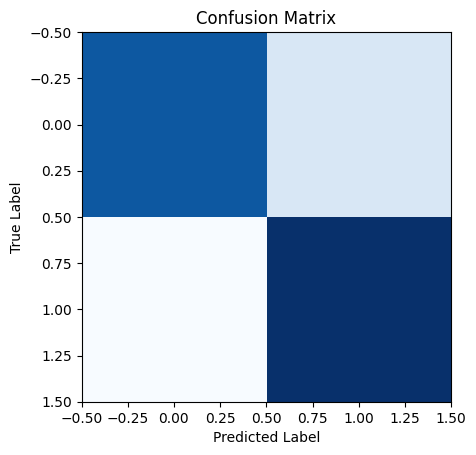

In [ ]:
def extractFeatures(audioFilePath):
    with wave.open(audioFilePath, "rb") as wav_file:                            # Opening the file in read-binary mode.
        num_channels = wav_file.getnchannels()                                  # Number of channels [mono or stereo --> audio from one source / multiple sources]
        rate = wav_file.getframerate()
        sig = wav_file.readframes(-1)                                           # Reads all audio frames from the file.
        sig = np.frombuffer(sig, dtype=np.int16)                                # Converting raw audio data to NumPy array.

    if num_channels == 1: # If mono audio detected
        sig = sig[:, np.newaxis]                                                # Reshape for consistency with stereo data.

    mfcc_feat = mfcc(sig, rate, winlen = 0.020, nfft = 1024, appendEnergy = False) # Calculating MFCC Features.
    mean_matrix = mfcc_feat.mean(0)                                             # Calculating mean of each MFCC coefficient across all frames.
    covariance = np.cov(np.transpose(mfcc_feat))                                # Calculating covariance matrix of MFCC features.
    return np.concatenate([mean_matrix, covariance.flatten()])                  # Concatenated array of mean matrix and flattened covariance matrix as the extracted features.

def train(features, labels):
    return features, labels                                                     # No training necessary on data.

def predict(features, labels, newFeature, k = 5):
    distances = np.linalg.norm(features - newFeature, axis = 1)                 # Calculating Euclidean distances between new feature and all training features.
    nearest_neighbors = np.argsort(distances)[:k]                               # Finds indices of k nearest neighbors based on distances.
    neighbor_labels = labels[nearest_neighbors]
    if neighbor_labels.dtype != int:                                            # Ensuring labels are integers for counting
        neighbor_labels = neighbor_labels.astype(int)
    counts = np.bincount(neighbor_labels)                                       # Counts occurrences of each unique label among k nearest neighbors.
    return counts.argmax().astype(labels.dtype)                                 # Returns most frequent label among k nearest neighbors as predicted label.

csvFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTrain.csv"
csvFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTrain.csv"
csvFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTrain.csv"
trainData = pd.read_csv(csvFileCombined)                                        #### Marker to change variable name when processing different CSV.

trainBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTrain[100]/"
trainBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTrain[100]/"
trainBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTrain[100]/"

selected_columns = ['% In-Tune Notes', 'Rhythmic Stability', 'Note Distribution Stability',
                    'Melodic Stability Range', 'Dynamic Variation']
features = []
labels = np.array([])

for index, row in trainData.iterrows():
    labels = np.concatenate((labels, [int(row['Significant'])]))
    audioFilePath = trainBasePathCombined + row['Filename']                     #### Marker to change variable name when processing different CSV.
    features.append(extractFeatures(audioFilePath))                             # Extracting features from audio file.

trainedFeatures, trainedLabels = train(features, labels)

testCSVFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTest.csv"
testCSVFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTest.csv"
testCSVFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTest.csv"
testData = pd.read_csv(testCSVFileCombined)                                     #### Marker to change variable name when processing different CSV.

testBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTest[50]/"
testBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTest[50]/"
testBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTest[52]/"

yTrue = np.array([int(row['Significant']) for index, row in testData.iterrows()])
yPredicted = []
for index, row in testData.iterrows():
    audioFilePath = testBasePathCombined + row['Filename']                      #### Marker to change variable name when processing different CSV.
    newFeature = extractFeatures(audioFilePath)                                 # Extracting features from audio file.
    prediction = predict(trainedFeatures, trainedLabels, newFeature)            # Predicting the label for current test audio.
    yPredicted.append(prediction)

accuracy = accuracy_score(yTrue, yPredicted)
precision = precision_score(yTrue, yPredicted)
recall = recall_score(yTrue, yPredicted)
print("Accuracy:", accuracy)
print()
print("Precision:", precision)
print()
print("Recall:", recall)
print()

cm = confusion_matrix(yTrue, yPredicted)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Audio Classification Model 2 [CNN]**

Epoch 1/20
4/4 [==============================] - 4s 731ms/step - loss: 57.3546 - accuracy: 0.5429 - val_loss: 56.2337 - val_accuracy: 0.3778
Epoch 2/20
4/4 [==============================] - 3s 638ms/step - loss: 15.6388 - accuracy: 0.8000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 5s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 3s 655ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 3s 643ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 0s 77ms/step
Accuracy: 1.0

Precision: 1.0

Recall: 1.0



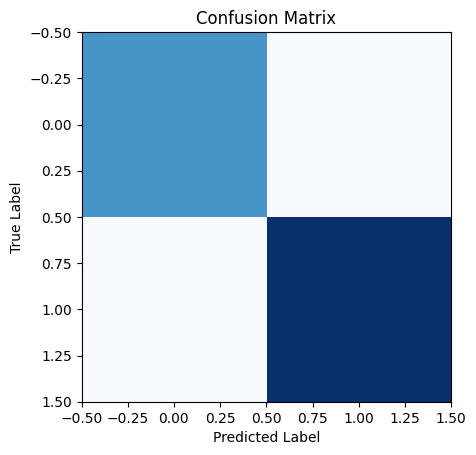

In [ ]:
# Load CSV Training Data
csvFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTrain.csv"
csvFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTrain.csv"
csvFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTrain.csv"
trainData = pd.read_csv(csvFileMono)                                            #### Marker to change variable name when processing different CSV.

trainBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTrain[100]/"
trainBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTrain[100]/"
trainBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTrain[100]/"

audioFiles = trainData["Filename"].tolist()                                     # Extract filenames from dataframe.
labels = trainData["Significant"].tolist()                                      # Extract labels from "Significant" column.

X = []
for file in audioFiles:
    fullPath = trainBasePathMono + file                                         #### Marker to change variable name when processing different CSV.
    data, sr = librosa.load(fullPath)
    stft = librosa.stft(data)                                                   # Compute short-time Fourier transform [STFT] of the audio
    stft_db = librosa.amplitude_to_db(abs(stft))                                # Converting STFT to decibel scale.
    stft_db_reshaped = np.resize(stft_db, (128, 128))
    X.append(stft_db_reshaped[..., np.newaxis])                                 # Appending reshaped STFT with new axis for 3D input.

X = np.array(X)                                                                 # Converting list of features to NumPy array.
y = labels

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3)          # Splitting the data into training and testing sets [70% training, 30% testing].
                                                                                # Doing this assesses how well the model is generalizing to unseen data to prevent overfitting.

# Load CSV Testing Data
testCSVFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTest.csv"
testCSVFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTest.csv"
testCSVFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTest.csv"
testData = pd.read_csv(testCSVFileMono)                                         #### Marker to change variable name when processing different CSV.

testBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTest[50]/"
testBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTest[50]/"
testBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTest[52]/"

audioFiles = testData["Filename"].tolist()                                      # Extract filenames from dataframe.
labels = testData["Significant"].tolist()                                       # Extract labels from "Significant" column.

X = []
for file in audioFiles:
    fullPath = testBasePathMono + file                                          #### Marker to change variable name when processing different CSV.
    data, sr = librosa.load(fullPath)
    stft = librosa.stft(data)                                                   # Compute short-time Fourier transform [STFT] of the audio
    stft_db = librosa.amplitude_to_db(abs(stft))                                # Converting STFT to decibel scale.
    stft_db_reshaped = np.resize(stft_db, (128, 128))
    X.append(stft_db_reshaped[..., np.newaxis])                                 # Appending reshaped STFT with new axis for 3D input.

X = np.array(X)                                                                 # Converting list of features to NumPy array.
yTrain = np.array(yTrain)
yTest = np.array(yTest)

model = tf.keras.Sequential([                                                   # Creating a sequential TensorFlow Model.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = xTrain.shape[1:]),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])                                                                              # Consists of two convolutional layers with ReLU activation and MaxPooling2D layers for
                                                                                # feature extraction. Flattening layer flattens the 2D output of convolutional layers to 1D for dense layers.
                                                                                # Dense layers: Fully conected layer with 128 neurons and ReLU activation, followed by final output layer with 1 neuron
                                                                                # and sigmoid activation for binary classification.

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Configuring the model for training with Adam optimizer, binary crossentropy loss, and accuracy metric.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5) # Creating an early stopping callback to stop training if validation accuracy does not improve for five epochs.
model.fit(xTrain, yTrain, epochs = 20, validation_data = (xTest, yTest), callbacks = [early_stopping]) # Training for maximum of 20 epochs, monitoring validation accuracy and using early stopping.
test_loss, test_acc = model.evaluate(xTest, yTest)                              # Evaluating model performance on test set.

yPredicted = model.predict(xTest)
yPredictedClasses = np.where(yPredicted > 0.5, 1, 0)                            # Apply threshold for binary classification

# Calculate metrics
accuracy = accuracy_score(yTest, yPredictedClasses)
precision = precision_score(yTest, yPredictedClasses)
recall = recall_score(yTest, yPredictedClasses)
print()
print("Accuracy:", accuracy)
print()
print("Precision:", precision)
print()
print("Recall:", recall)
print()

# Generate confusion matrix
cm = confusion_matrix(yTest, yPredictedClasses)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# model.save('monoModel.h5')                                                    Optionally, save the trained model for future use

Epoch 1/20
3/3 [==============================] - 7s 980ms/step - loss: 87.8188 - accuracy: 0.4714 - val_loss: 9.7288 - val_accuracy: 0.7333
Epoch 2/20
3/3 [==============================] - 3s 899ms/step - loss: 6.0938 - accuracy: 0.8429 - val_loss: 2.3875e-21 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 3s 917ms/step - loss: 4.2567e-22 - accuracy: 1.0000 - val_loss: 4.5237e-32 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 3s 903ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 8.0069e-34 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 4s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.9214e-33 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 3s 917ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 8.5315e-32 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 288ms/step

Accuracy: 1.0

Precision: 1.0

Recall: 1.0



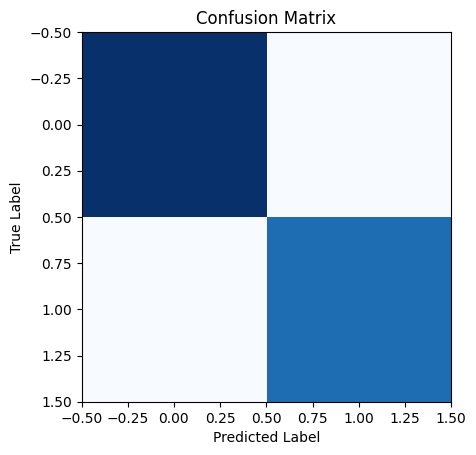

In [ ]:
# Load CSV Training Data
csvFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTrain.csv"
csvFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTrain.csv"
csvFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTrain.csv"
trainData = pd.read_csv(csvFilePoly)                                            #### Marker to change variable name when processing different CSV.

trainBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTrain[100]/"
trainBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTrain[100]/"
trainBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTrain[100]/"

audioFiles = trainData["Filename"].tolist()                                     # Extract filenames from dataframe.
labels = trainData["Significant"].tolist()                                      # Extract labels from "Significant" column.

X = []
for file in audioFiles:
    fullPath = trainBasePathPoly + file                                         #### Marker to change variable name when processing different CSV.
    data, sr = librosa.load(fullPath)
    stft = librosa.stft(data)                                                   # Compute short-time Fourier transform [STFT] of the audio
    stft_db = librosa.amplitude_to_db(abs(stft))                                # Converting STFT to decibel scale.
    stft_db_reshaped = np.resize(stft_db, (128, 128))
    X.append(stft_db_reshaped[..., np.newaxis])                                 # Appending reshaped STFT with new axis for 3D input.

X = np.array(X)                                                                 # Converting list of features to NumPy array.
y = labels

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3)          # Splitting the data into training and testing sets [70% training, 30% testing].
                                                                                # Doing this assesses how well the model is generalizing to unseen data to prevent overfitting.

# Load CSV Testing Data
testCSVFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTest.csv"
testCSVFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTest.csv"
testCSVFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTest.csv"
testData = pd.read_csv(testCSVFilePoly)                                         #### Marker to change variable name when processing different CSV.

testBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTest[50]/"
testBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTest[50]/"
testBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTest[52]/"

audioFiles = testData["Filename"].tolist()                                      # Extract filenames from dataframe.
labels = testData["Significant"].tolist()                                       # Extract labels from "Significant" column.

X = []
for file in audioFiles:
    fullPath = testBasePathPoly + file                                          #### Marker to change variable name when processing different CSV.
    data, sr = librosa.load(fullPath)
    stft = librosa.stft(data)                                                   # Compute short-time Fourier transform [STFT] of the audio
    stft_db = librosa.amplitude_to_db(abs(stft))                                # Converting STFT to decibel scale.
    stft_db_reshaped = np.resize(stft_db, (128, 128))
    X.append(stft_db_reshaped[..., np.newaxis])                                 # Appending reshaped STFT with new axis for 3D input.

X = np.array(X)                                                                 # Converting list of features to NumPy array.
yTrain = np.array(yTrain)
yTest = np.array(yTest)

model = tf.keras.Sequential([                                                   # Creating a sequential TensorFlow Model.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = xTrain.shape[1:]),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])                                                                              # Consists of two convolutional layers with ReLU activation and MaxPooling2D layers for
                                                                                # feature extraction. Flattening layer flattens the 2D output of convolutional layers to 1D for dense layers.
                                                                                # Dense layers: Fully conected layer with 128 neurons and ReLU activation, followed by final output layer with 1 neuron
                                                                                # and sigmoid activation for binary classification.

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Configuring the model for training with Adam optimizer, binary crossentropy loss, and accuracy metric.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5) # Creating an early stopping callback to stop training if validation accuracy does not improve for five epochs.
model.fit(xTrain, yTrain, epochs = 20, validation_data = (xTest, yTest), callbacks = [early_stopping]) # Training for maximum of 20 epochs, monitoring validation accuracy and using early stopping.
test_loss, test_acc = model.evaluate(xTest, yTest)                              # Evaluating model performance on test set.

yPredicted = model.predict(xTest)
yPredictedClasses = np.where(yPredicted > 0.5, 1, 0)                            # Apply threshold for binary classification

# Calculate metrics
accuracy = accuracy_score(yTest, yPredictedClasses)
precision = precision_score(yTest, yPredictedClasses)
recall = recall_score(yTest, yPredictedClasses)
print()
print("Accuracy:", accuracy)
print()
print("Precision:", precision)
print()
print("Recall:", recall)
print()

# Generate confusion matrix
cm = confusion_matrix(yTest, yPredictedClasses)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# model.save('monoModel.h5')                                                    Optionally, save the trained model for future use

Epoch 1/20
3/3 [==============================] - 4s 838ms/step - loss: 183.6625 - accuracy: 0.5571 - val_loss: 74.5058 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 2s 680ms/step - loss: 57.6397 - accuracy: 0.5429 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 3s 951ms/step - loss: 9.5516e-25 - accuracy: 1.0000 - val_loss: 2.0132e-16 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 3s 888ms/step - loss: 0.3356 - accuracy: 0.9571 - val_loss: 6.8951e-15 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 2s 693ms/step - loss: 2.2418e-16 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 2s 658ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 252ms/step

Accuracy: 1.0

Precision: 1.0

Recall: 1.0



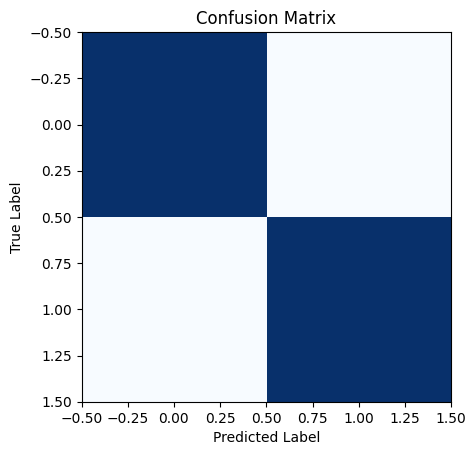

In [ ]:
# Load CSV Training Data
csvFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTrain.csv"
csvFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTrain.csv"
csvFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTrain.csv"
trainData = pd.read_csv(csvFileCombined)                                        #### Marker to change variable name when processing different CSV.

trainBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTrain[100]/"
trainBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTrain[100]/"
trainBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTrain[100]/"

audioFiles = trainData["Filename"].tolist()                                     # Extract filenames from dataframe.
labels = trainData["Significant"].tolist()                                      # Extract labels from "Significant" column.

X = []
for file in audioFiles:
    fullPath = trainBasePathCombined + file                                     #### Marker to change variable name when processing different CSV.
    data, sr = librosa.load(fullPath)
    stft = librosa.stft(data)                                                   # Compute short-time Fourier transform [STFT] of the audio
    stft_db = librosa.amplitude_to_db(abs(stft))                                # Converting STFT to decibel scale.
    stft_db_reshaped = np.resize(stft_db, (128, 128))
    X.append(stft_db_reshaped[..., np.newaxis])                                 # Appending reshaped STFT with new axis for 3D input.

X = np.array(X)                                                                 # Converting list of features to NumPy array.
y = labels

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3)          # Splitting the data into training and testing sets [70% training, 30% testing].
                                                                                # Doing this assesses how well the model is generalizing to unseen data to prevent overfitting.

# Load CSV Testing Data
testCSVFileMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/monoNottinghamTest.csv"
testCSVFilePoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/polyMaestroTest.csv"
testCSVFileCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/combinedTest.csv"
testData = pd.read_csv(testCSVFileCombined)                                     #### Marker to change variable name when processing different CSV.

testBasePathMono = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/NottinghamMonoTest[50]/"
testBasePathPoly = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/MaestroPolyTest[50]/"
testBasePathCombined = "/content/drive/Shareddrives/neotyagi-dataset/CSV Creation/CombinedTest[52]/"

audioFiles = testData["Filename"].tolist()                                      # Extract filenames from dataframe.
labels = testData["Significant"].tolist()                                       # Extract labels from "Significant" column.

X = []
for file in audioFiles:
    fullPath = testBasePathCombined + file                                      #### Marker to change variable name when processing different CSV.
    data, sr = librosa.load(fullPath)
    stft = librosa.stft(data)                                                   # Compute short-time Fourier transform [STFT] of the audio
    stft_db = librosa.amplitude_to_db(abs(stft))                                # Converting STFT to decibel scale.
    stft_db_reshaped = np.resize(stft_db, (128, 128))
    X.append(stft_db_reshaped[..., np.newaxis])                                 # Appending reshaped STFT with new axis for 3D input.

X = np.array(X)                                                                 # Converting list of features to NumPy array.
yTrain = np.array(yTrain)
yTest = np.array(yTest)

model = tf.keras.Sequential([                                                   # Creating a sequential TensorFlow Model.
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = xTrain.shape[1:]),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])                                                                              # Consists of two convolutional layers with ReLU activation and MaxPooling2D layers for
                                                                                # feature extraction. Flattening layer flattens the 2D output of convolutional layers to 1D for dense layers.
                                                                                # Dense layers: Fully conected layer with 128 neurons and ReLU activation, followed by final output layer with 1 neuron
                                                                                # and sigmoid activation for binary classification.

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Configuring the model for training with Adam optimizer, binary crossentropy loss, and accuracy metric.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5) # Creating an early stopping callback to stop training if validation accuracy does not improve for five epochs.
model.fit(xTrain, yTrain, epochs = 20, validation_data = (xTest, yTest), callbacks = [early_stopping]) # Training for maximum of 20 epochs, monitoring validation accuracy and using early stopping.
test_loss, test_acc = model.evaluate(xTest, yTest)                              # Evaluating model performance on test set.

yPredicted = model.predict(xTest)
yPredictedClasses = np.where(yPredicted > 0.5, 1, 0)                            # Apply threshold for binary classification

# Calculate metrics
accuracy = accuracy_score(yTest, yPredictedClasses)
precision = precision_score(yTest, yPredictedClasses)
recall = recall_score(yTest, yPredictedClasses)
print()
print("Accuracy:", accuracy)
print()
print("Precision:", precision)
print()
print("Recall:", recall)
print()

# Generate confusion matrix
cm = confusion_matrix(yTest, yPredictedClasses)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# model.save('monoModel.h5')                                                    Optionally, save the trained model for future use